In [149]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon, pearsonr
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import seaborn as sns
import traceback
from itertools import product
import colorsys
import pingouin as pg

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']

stimrespdecodingfilename = 'D:\\stimdecoding_resp.csv'
stim25sdecodingfilename = 'D:\\stimdecoding_25s.csv'
stimbufferdecodingfilename = 'D:\\stimdecoding_25s_buffer.csv'
stimnobufferdecodingfilename = 'D:\\stimdecoding_25s_nobuffer.csv'
stimnotrimdecodingfilename = 'D:\\stimdecoding_25s_notrim.csv'
choicedecodingfilename = 'D:\\choicedecoding.csv'

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'P:\\Behavioor'

In [76]:
timescale = 15 #trials

In [127]:
sessionfile = ilep.getRandomSession(act_directory)
sessionfile.meta

namespace(directory='D:\\DualRecording\\BS_49\\BS_49 16\\M2\\',
          region='M2',
          animal='BS_49',
          probe=7373,
          date='9/22/2021',
          depth=1300,
          task='reversal',
          day_of_training=16,
          day_of_recording=15,
          day_of_reversal=2,
          length_in_samples=98418689.0,
          files=['September 22 2021 Dual BS_49_16001',
                 'September 22 2021 Dual BS_49_16002',
                 'September 22 2021 Dual BS_49_16003',
                 'September 22 2021 Dual BS_49_16004'],
          behavior='naive',
          condition='postreversal naive',
          arraystart=0,
          tonelength=0.1,
          triallength=2.5,
          lickdelayrelativetostart=0.2,
          lickdelayrelativetotone=0.1,
          fs=30000,
          length_in_seconds=3280.622966666667,
          length_in_minutes=54.67704944444445,
          length_in_trials=538)

In [128]:
num_bins = 25
spike_counts = np.zeros((len(sessionfile.clusters.good),sessionfile.meta.length_in_trials,num_bins))

for clust_idx,clust in tqdm(enumerate(sessionfile.clusters.good)):
    spikes_clust = ilep.getSpikeTimes(sessionfile,clust=clust)
    for trial_idx,trial in enumerate(range(sessionfile.meta.length_in_trials)):
        spikes_trial = ilep.getSpikeTimes(sessionfile,starttime=sessionfile.trials.starts[trial],endtime=sessionfile.trials.starts[trial]+2.5*sessionfile.meta.fs,cachedtimes=spikes_clust)
        bins = np.linspace(0,2.5,num_bins+1)
        for bin_idx,(bin_start,bin_end) in enumerate(zip( bins[0:len(bins)],bins[1:len(bins+1)] )):
            #print(f"cluster {clust}, trial {trial}, bin from {bin_start} to {bin_end}")
            window_start = sessionfile.trials.starts[trial]+bin_start*sessionfile.meta.fs
            window_end = sessionfile.trials.starts[trial]+bin_end*sessionfile.meta.fs
            spikes = ilep.getSpikeTimes(sessionfile,starttime=window_start,endtime=window_end,cachedtimes=spikes_trial)
            spike_counts[clust_idx,trial_idx,bin_idx] = len(spikes)

2it [00:00,  6.33it/s]


In [129]:
mean_counts_target = np.mean(spike_counts[:,sessionfile.trials.target,:],axis=1)
mean_counts_nontarget = np.mean(spike_counts[:,np.logical_not(sessionfile.trials.target),:],axis=1)

residual_spike_counts = np.copy(spike_counts)
for trial_idx,trial in enumerate(range(sessionfile.meta.length_in_trials)):
    if sessionfile.trials.target[trial]:
        residual_spike_counts[:,trial_idx,:] -= mean_counts_target
    else:
        residual_spike_counts[:,trial_idx,:] -= mean_counts_nontarget

In [130]:
outcomes = ilep.getOutcomesFromSession(sessionfile)
window_length = 50    

hits = np.equal(outcomes,1)
misses = np.equal(outcomes,2)
falarms = np.equal(outcomes,3)
crejects = np.equal(outcomes,4)
gos = np.logical_or(hits,falarms)
nogos = np.logical_or(misses,crejects)

#Determine lick rate over time
number_windows = len(outcomes) - window_length + 1
if number_windows <= 0:
    raise Exception('No Windows')
    
lick_rates = np.full(number_windows,np.nan)
neural_activity = np.full((len(sessionfile.clusters.good),number_windows),np.nan)
for window_idx in range(number_windows):

    window_trials = list(range(window_idx,window_idx+window_length))
    
    window_gos = gos[window_trials]
    window_lick_rate = np.mean(window_gos)
    lick_rates[window_idx] = window_lick_rate
    
    neural_activity[:,window_idx] = np.mean(residual_spike_counts[:,window_trials],axis=(1,2))

[0.97256035]
[7.20434517]
-0.0018837791423673793
0.0018346505394825842


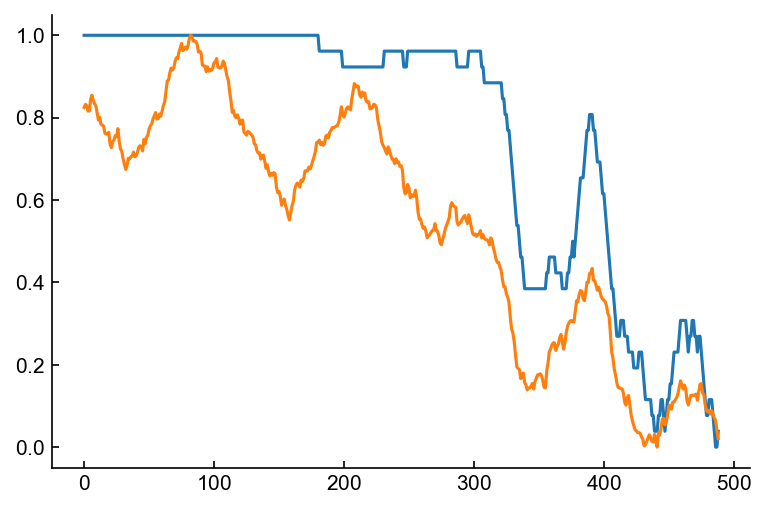

In [135]:
def normalize(X):
    X = X - np.min(X)
    X = X / np.max(X)
    return X

pca = PCA(n_components=1)
pca.fit(neural_activity.T)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

Y = normalize(lick_rates)
X = np.array(range(len(Y)))
X =  X.reshape(-1, 1)
reg_lick = LinearRegression().fit(X,Y)
plt.plot(X,Y)

Y = normalize(pca.transform(neural_activity.T))
X = np.array(range(len(Y)))
X =  X.reshape(-1, 1)
reg_act = LinearRegression().fit(X,Y)

print(reg_lick.coef_[0])
print(reg_act.coef_[0][0])

if (reg_lick.coef_[0]>0) != (reg_act.coef_[0]>0):
    Y = 1-Y
plt.plot(X,Y)

In [198]:
def normalize(X):
    X = X - np.min(X)
    X = X / np.max(X)
    return X

def getSlowDrift(sessionfile,window_length=50,active_threshold=0):
    cells = []
    for clust in sessionfile.clusters.good:
        if len(sessionfile.trim[clust].trimmed_trials) >= active_threshold*sessionfile.meta.length_in_trials:
            cells.append(clust)
    if len(cells) < 5:
        return None,None,None,None
    
    #Calculate spike counts
    num_bins = 25
    spike_counts = np.zeros((len(cells),sessionfile.meta.length_in_trials,num_bins))

    for clust_idx,clust in tqdm(enumerate(cells)):
        spikes_clust = ilep.getSpikeTimes(sessionfile,clust=clust)
        for trial_idx,trial in enumerate(range(sessionfile.meta.length_in_trials)):
            spikes_trial = ilep.getSpikeTimes(sessionfile,starttime=sessionfile.trials.starts[trial],endtime=sessionfile.trials.starts[trial]+2.5*sessionfile.meta.fs,cachedtimes=spikes_clust)
            bins = np.linspace(0,2.5,num_bins+1)
            for bin_idx,(bin_start,bin_end) in enumerate(zip( bins[0:len(bins)],bins[1:len(bins+1)] )):
                #print(f"cluster {clust}, trial {trial}, bin from {bin_start} to {bin_end}")
                window_start = sessionfile.trials.starts[trial]+bin_start*sessionfile.meta.fs
                window_end = sessionfile.trials.starts[trial]+bin_end*sessionfile.meta.fs
                spikes = ilep.getSpikeTimes(sessionfile,starttime=window_start,endtime=window_end,cachedtimes=spikes_trial)
                spike_counts[clust_idx,trial_idx,bin_idx] = len(spikes)
                
    #Calculate residuals
    mean_counts_target = np.mean(spike_counts[:,sessionfile.trials.target,:],axis=1)
    mean_counts_nontarget = np.mean(spike_counts[:,np.logical_not(sessionfile.trials.target),:],axis=1)

    residual_spike_counts = np.copy(spike_counts)
    for trial_idx,trial in enumerate(range(sessionfile.meta.length_in_trials)):
        if sessionfile.trials.target[trial]:
            residual_spike_counts[:,trial_idx,:] -= mean_counts_target
        else:
            residual_spike_counts[:,trial_idx,:] -= mean_counts_nontarget
            
    #Get windowed lick rate and activity
    outcomes = ilep.getOutcomesFromSession(sessionfile)
    window_length = 50    

    hits = np.equal(outcomes,1)
    misses = np.equal(outcomes,2)
    falarms = np.equal(outcomes,3)
    crejects = np.equal(outcomes,4)
    gos = np.logical_or(hits,falarms)
    nogos = np.logical_or(misses,crejects)

    #Determine lick rate over time
    number_windows = len(outcomes) - window_length + 1
    if number_windows <= 0:
        raise Exception('No Windows')

    lick_rates = np.full(number_windows,np.nan)
    neural_activity = np.full((len(cells),number_windows),np.nan)
    for window_idx in range(number_windows):

        window_trials = list(range(window_idx,window_idx+window_length))

        window_gos = gos[window_trials]
        window_lick_rate = np.mean(window_gos)
        lick_rates[window_idx] = window_lick_rate

        neural_activity[:,window_idx] = np.mean(residual_spike_counts[:,window_trials],axis=(1,2))
        
    #Get drift
    pca = PCA(n_components=1)
    pca.fit(neural_activity.T)
    print(pca.explained_variance_ratio_)
    print(pca.singular_values_)

    Y = normalize(lick_rates)
    X = np.array(range(len(Y)))
    X =  X.reshape(-1, 1)
    reg_lick = LinearRegression().fit(X,Y)
    behavior_drift = np.copy(Y)

    Y = normalize(pca.transform(neural_activity.T))
    X = np.array(range(len(Y)))
    X =  X.reshape(-1, 1)
    reg_act = LinearRegression().fit(X,Y)

    print(reg_lick.coef_[0])
    print(reg_act.coef_[0][0])

    if (reg_lick.coef_[0]>0) != (reg_act.coef_[0]>0):
        Y = 1-Y
    activity_drift = np.copy(Y)
    
    #Get R^2
    r2,_ = pearsonr(behavior_drift,activity_drift)
    
    return behavior_drift,activity_drift,r2,cells

6it [00:00,  8.24it/s]


[0.67937738]
[10.33174756]
-0.0016621540416932401
-0.001877473877211832


31it [00:03,  9.39it/s]


[0.56097556]
[14.46318319]
-0.002885911137049192
-0.002375014729798977


22it [00:02,  9.44it/s]


[0.56149347]
[12.15620419]
-0.002130629497778002
0.00196436870974535


17it [00:02,  6.62it/s]


[0.89033413]
[42.9096061]
-0.0018628657185816775
0.002085922633612918


19it [00:02,  9.11it/s]


[0.70635897]
[15.7501366]
-0.0018614303998873872
-0.0023783532817227755


23it [00:03,  7.17it/s]


[0.64099578]
[62.83024071]
-0.00233216794159568
0.002465965711164712


12it [00:01, 10.96it/s]


[0.74737916]
[19.82643876]
-0.003013532631274097
-0.0032520584239860285


11it [00:01, 10.17it/s]


[0.74657238]
[18.41142281]
-0.0024587733858571444
-0.0030854106326747865


6it [00:00,  7.27it/s]


[0.78672047]
[9.9085585]
-0.001637534555895867
-0.0004684278671905923


13it [00:01,  8.38it/s]


[0.48955426]
[5.40315691]
-0.001711793312241952
-0.00017709992192646554


12it [00:01,  9.45it/s]


[0.51156325]
[9.30077275]
-0.002843870704852172
0.0026574124877672667


5it [00:00,  8.43it/s]


[0.8661757]
[19.40436503]
-0.0019808256536211623
-0.0022000711311778187


55it [00:05, 10.46it/s]


[0.51670713]
[22.65371026]
-0.0022636357085071266
-0.0031888795121107535


29it [00:03,  9.62it/s]


[0.51006941]
[10.61583088]
-0.0021722728254926224
0.0023141699071731704


8it [00:00,  8.06it/s]


[0.8963086]
[27.51888103]
-0.0017349264027542704
-0.001471790714270947


10it [00:01,  6.62it/s]


[0.5250117]
[10.28421985]
-0.0017717004762912356
-0.0007647011177869768


8it [00:00,  8.51it/s]


[0.85113188]
[5.89625896]
-0.0005023091751783637
0.0008487668215414925


16it [00:02,  7.86it/s]


[0.771742]
[16.1640367]
-0.0017380161463068037
-0.0020935201056303736


38it [00:03, 11.00it/s]


[0.67374976]
[57.54646933]
-0.002731461892516765
-0.0029027797124806676


10it [00:00, 11.01it/s]


[0.73981898]
[8.67218887]
0.00015328607871080297
0.0011240784984880917


29it [00:03,  7.41it/s]


[0.57389799]
[24.60127961]
-0.0019885280473858104
-0.002261693093823623


9it [00:01,  8.02it/s]


[0.75716594]
[17.13504638]
-0.0020857941082818732
-0.0018950608692443213


5it [00:00,  6.79it/s]


[0.55724678]
[3.91513486]
-0.0014990614672891758
8.247596467632814e-05


16it [00:02,  6.89it/s]


[0.76756569]
[20.96175586]
-0.0013912825313417308
-0.0018372155227838374


20it [00:02,  7.86it/s]


[0.54659492]
[22.4549374]
-0.00039930112696139037
-0.0015205002636926475


13it [00:01,  6.69it/s]


[0.74439086]
[13.32124326]
-0.0012233872022398807
-0.00041179752994468594


9it [00:01,  8.09it/s]


[0.47135865]
[7.90025309]
-0.0021460182272147886
0.0012753046822420698


18it [00:02,  8.55it/s]


[0.71710641]
[8.51439983]
6.797088083511515e-05
-0.002618675790959429


39it [00:04,  8.00it/s]


[0.65133236]
[23.53407479]
-0.0010285748338845681
-0.002007929837394408


30it [00:04,  6.71it/s]


[0.47805706]
[19.4126786]
-0.0008801880672787321
-0.0015235577748846723


30it [00:04,  6.37it/s]


[0.49308914]
[22.73349774]
-0.001886797536626634
-0.001627919870495801


13it [00:01,  8.11it/s]


[0.45668788]
[8.3787779]
-0.0014604785897684653
0.0011208354006794145


26it [00:03,  6.85it/s]


[0.71018802]
[19.78168589]
-0.0012110078334038724
-0.002059266584924095


31it [00:04,  6.69it/s]


[0.41585975]
[9.75001938]
-0.0011135979059911827
-0.0014715086443622568


6it [00:00,  8.10it/s]


[0.57192692]
[21.00046638]
-0.0022846396486718664
-0.0002690421716175512


52it [00:04, 11.07it/s]


[0.50771674]
[21.37873012]
-0.0028702817772679125
-0.0036200500414004743


31it [00:03,  9.66it/s]


[0.58341248]
[28.77835308]
-0.0018506197161939416
0.0027097457763411398


27it [00:01, 23.26it/s]


[0.88120333]
[7.38574679]
-0.0016475729414637133
0.008012292458316722


5it [00:00, 18.68it/s]


[0.79181674]
[4.61020657]
0.00021534149663433313
-0.004339361468140267


15it [00:00, 15.09it/s]


[0.67072595]
[17.18712944]
-0.0053909808761262576
-0.003530563552382908


21it [00:00, 32.03it/s]


[0.79841223]
[4.00497879]
-0.013463246724405955
0.012147435037909219


12it [00:01, 11.67it/s]


[0.78917754]
[11.13039095]
-0.0035365680617929275
-0.0029991243967373723


6it [00:00,  7.12it/s]


[0.94611377]
[16.25558549]
-0.0014630070848558052
-0.0015778196871918913


10it [00:01,  8.28it/s]


[0.66911418]
[31.4541218]
-0.0018534693268230898
-0.002118795242957721


8it [00:00,  8.70it/s]


[0.85747896]
[13.74689546]
-0.0020127491722486666
-0.0016471759678619107


7it [00:01,  5.74it/s]


[0.52595324]
[15.03188969]
-9.52322959051634e-05
0.00010746032295093043


11it [00:01,  7.81it/s]


[0.82328697]
[8.97493611]
-0.0021514076760158294
-0.0013584520609797807


9it [00:00,  9.07it/s]


[0.86814861]
[16.44283073]
-0.0029127265652282167
-0.0028387330593616926


9it [00:00, 10.32it/s]


[0.74296492]
[12.64908438]
-0.0030754978815123167
-0.002554084573932824


5it [00:00,  8.23it/s]


[0.82221061]
[15.00984938]
-0.002083697724213244
-0.0020200534392480927


27it [00:03,  7.37it/s]


[0.55787357]
[19.98123591]
-0.0013268165805213783
-0.0021622733212695914


14it [00:01, 10.78it/s]


[0.79279434]
[10.29710741]
-0.003523828777037219
-0.0019423038768883983


8it [00:00, 10.36it/s]


[0.754148]
[13.92497501]
-0.003130282166005115
-0.0035615266289830303


15it [00:01,  8.04it/s]


[0.83564567]
[19.26775966]
-0.0028820455425139888
-0.001637002450788602


16it [00:01,  8.16it/s]


[0.65675233]
[9.19227989]
-0.0017468372583895068
-0.0020614951560270958


7it [00:00, 14.00it/s]


[0.93300372]
[18.78995515]
-0.00407391890608128
0.0034946498786450307


19it [00:02,  7.22it/s]


[0.76577416]
[22.23265636]
-0.0015367151477044603
0.0019118102378062648


12it [00:01, 10.28it/s]


[0.84472393]
[22.54714903]
-0.0024280481423338564
0.003009414599102972


12it [00:01,  6.74it/s]


[0.73527072]
[17.52640861]
0.0002593135793999477
-0.0015002142203173713


25it [00:02, 10.40it/s]


[0.83724508]
[25.41661873]
-0.0034186947117185538
-0.003590513479543143


15it [00:01,  7.90it/s]


[0.61613084]
[15.73101188]
-0.0016201763557688442
-0.0025023225440924746


23it [00:02,  8.09it/s]


[0.68325205]
[15.4637986]
-0.0023386610910893246
0.002316845338366102


8it [00:00, 10.62it/s]


[0.9385187]
[17.30350589]
-0.0022781943322549188
-0.003476276141239265


10it [00:00, 20.57it/s]


[0.79878378]
[5.73684289]
-0.00513311230370346
-0.005870420815307711


5it [00:00,  7.80it/s]


[0.71545419]
[4.35356763]
-0.0013526498239044434
-0.0022946426941925654


8it [00:00,  8.04it/s]


[0.64923148]
[14.18621242]
-0.0017253686049297908
0.0006730696768801501


40it [00:04,  9.56it/s]


[0.58667481]
[19.65295813]
-0.002618400389860405
0.0028021206112009093


29it [00:02,  9.87it/s]


[0.53944099]
[12.23277095]
-0.0028180406705200518
0.0028002424544735696


16it [00:01, 10.23it/s]


[0.65159884]
[9.27686306]
-0.003254228913311805
-0.0015156639766108959


9it [00:00, 10.57it/s]


[0.67260946]
[4.93592183]
-0.001572545595168194
-0.00203577199390213


28it [00:03,  8.31it/s]


[0.68867763]
[26.18525804]
-0.0007741341078308839
-0.002377198803283196


15it [00:02,  7.27it/s]


[0.64858893]
[20.38800947]
-0.0013706693168819698
0.0024747073944763514


21it [00:03,  5.82it/s]


[0.61389965]
[18.17547645]
-0.0019345007296542832
-0.0013851401992239065


7it [00:00,  7.62it/s]


[0.72656998]
[6.64965167]
-0.002019746116608151
-0.0019414428238144757


16it [00:02,  6.58it/s]


[0.79575273]
[27.05688209]
-0.0020752224805647263
-0.0019282293073752108


33it [00:03,  8.55it/s]


[0.66050321]
[21.03931544]
-0.0025130403002204334
-0.0028620192987365155


25it [00:03,  7.29it/s]


[0.74843414]
[30.56920633]
-0.0015209138699062777
0.0020698231092046338


6it [00:00,  8.11it/s]


[0.70247332]
[4.74898345]
-0.0017637680980367497
-0.002030756299144112


14it [00:01, 13.50it/s]


[0.56491086]
[6.81290277]
-0.002649754722606175
0.004791613850008137


17it [00:01, 12.81it/s]


[0.85704038]
[19.6527878]
-0.0025531072986963717
-0.004023637057380204


18it [00:01, 13.49it/s]


[0.83580964]
[21.80685623]
-0.002330543517814021
-0.004334046003642238


18it [00:01, 10.23it/s]


[0.60272898]
[12.79751276]
-0.002101906030477458
-0.002326184439666511


22it [00:01, 13.48it/s]


[0.56449576]
[10.98476482]
-0.0022552330361095317
0.003252023246410779


5it [00:00,  8.93it/s]


[0.770873]
[6.80226491]
-0.0012922760304596092
-0.001546869415339939


10it [00:00, 12.17it/s]


[0.78379432]
[21.25076575]
-0.003039016823768045
-0.0037877174858945446


8it [00:00,  8.15it/s]


[0.77088869]
[20.04842809]
-0.0015562887690490624
-0.0020546881807617687


7it [00:00, 10.92it/s]


[0.55091723]
[7.29987212]
-0.0020632150514333417
0.003064856397570693


5it [00:00, 13.15it/s]


[0.80692439]
[4.76068088]
-2.8246801155166988e-05
0.0024568485314848607


8it [00:00, 10.07it/s]


[0.65285699]
[10.53224095]
-0.002599206349206347
-0.002468629293070175


15it [00:01,  7.91it/s]


[0.73331999]
[24.74698715]
-0.001782441328027971
0.00217743078859119


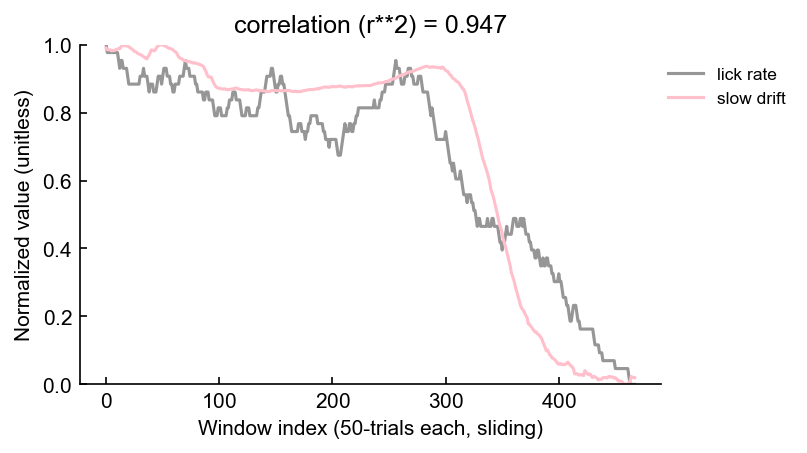

In [199]:
num_cells = []
r2s = []

for session in os.listdir(act_directory):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.length_in_trials < 100:
        continue
    if len(sessionfile.clusters.good) < 5:
        continue
    if sessionfile.meta.task not in ['nonreversal','switch','reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
    if sessionfile.meta.animal not in ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_16','DS_19']:
        continue

    beh,act,r2,cells = getSlowDrift(sessionfile)
    if beh is None:
        continue
    
    num_cells.append(len(cells))
    r2s.append(r2)
    X = range(len(beh))

    plt.close('all')
    fig, ax = plt.subplots(figsize=(5,3))
    ax.plot(X,beh,color=GOOD_GREY,label='lick rate')
    ax.plot(X,act,color='pink',label='slow drift')
    ax.set_ylim([0,1])

    ax.set_xlabel('Window index (50-trials each, sliding)')
    ax.set_ylabel('Normalized value (unitless)')
    
    ax.set_title(f"correlation (r**2) = {np.round(r2[0]*1000)/1000}")

    lgd = ax.legend(frameon=False,loc=(1,0.8))

    fig.savefig(os.path.join('D:\\TempFigures','Slow Drift Figures',f"{ilep.generateDateString(sessionfile)} slow drift vs behavior"),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [200]:
r2s = np.abs(r2s)

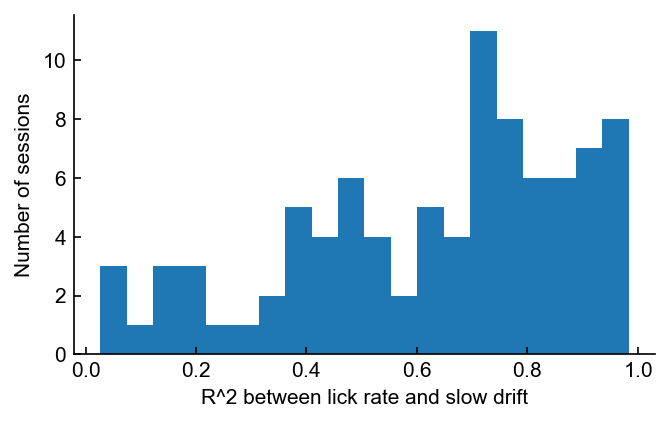

In [205]:
fig, ax = plt.subplots(figsize=(5,3))

ax.hist(r2s,bins=20)
ax.set_xlabel('R^2 between lick rate and slow drift')
ax.set_ylabel('Number of sessions')

fig.savefig(os.path.join('D:\\TempFigures','Slow Drift Figures',f"R^2 Histogram"),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')

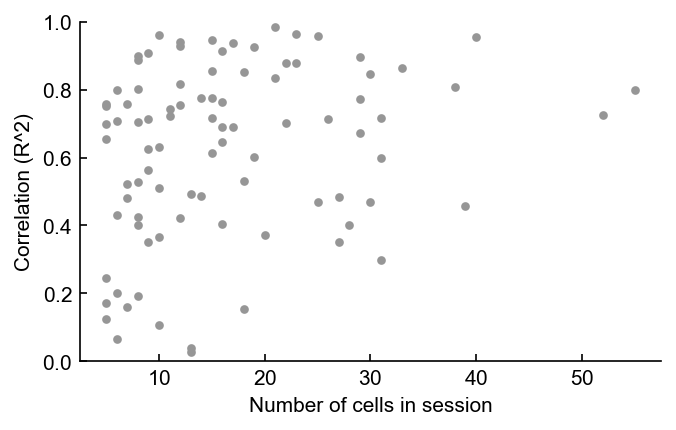

In [208]:
fig, ax = plt.subplots(figsize=(5,3))

ax.scatter(num_cells,r2s,color=GOOD_GREY,s=10)
ax.set_ylim([0,1])
ax.set_xlabel('Number of cells in session')
ax.set_ylabel('Correlation (R^2)')

fig.savefig(os.path.join('D:\\TempFigures','Slow Drift Figures',f"Correlation vs number of clusters"),transparent=False,facecolor="white", bbox_extra_artists=(lgd,), bbox_inches='tight')